In [26]:
import sys
from pathlib import Path

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns

this_path = Path(__file__) if '__file__' in globals() else Path("<unknown>.ipynb").resolve()
work_path = next((p for p in this_path.parents if p.name == "research"), None)
tools_path = work_path / Path("../torch-tools")
sys.path.append(str(tools_path))

from exp_manager import cat_results
import pl_utils


In [27]:
pl_utils.Config()

p_path = this_path.parent
print(p_path)

paths = [p_path]
# paths = [p_path / "exp_*"]

df_base = cat_results(paths)
df_base = df_base.filter(pl.col("epochs") == pl.col("epoch").list.last())

# df_base.pipe(pl_utils.resolve_nested).write_csv(p_path / "df_base.csv")

print(df_base.columns)
print(df_base)

/newssd/projects/tat/research/ee/ee_experiments/20260119_ds_robust/exp_robust
['exp_name', 'run_id', 'model_arc', 'train_dataset', 'val_dataset', 'num_classes', 'train_trans', 'val_trans', 'train_ndata', 'val_ndata', 'ipc', 'ipc_is_balanced', 'ipc_info', 'epochs', 'max_lr', 'wd', 'batch_size', 'iters/epoch', 'iters', 'processed_ndata', 'div', 'ensembles', 'scale_ch', 'refiner', 'num_params', 'criterion', 'optimizer', 'scheduler', 'step', 'epoch', 'lr', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'dur_total_core', 'dur_total_core_fmt', 'dur_train_core', 'dur_train_core_fmt', 'dur_total', 'dur_total_fmt', 'dur_train', 'dur_train_fmt', 'progress']
shape: (159, 44)
┌────────────┬───────────────────────────┬───────────┬───────────────┬─────────────┬─────────────┬───────────────────────────┬───────────────────────────┬─────────────┬───────────┬───────┬─────────────────┬───────────────────────────┬────────┬─────────┬──────┬────────────┬─────────────┬───────┬─────────────────┬─────┬─────

In [28]:
df_b = df_base
# df_b = df_b.pipe(pl_utils.add_iter_epoch).pipe(pl_utils.unnest_iter)

# df_b = df_b.filter(pl.col("optimizer") == "SGD")
# df_b = df_b.filter(pl.col("train_ndata").is_in([10000, 5000]))
# df_b = df_b.filter(pl.col("model_arc").str.contains("cifar"))



In [29]:
df_e = df_b
df_e = df_b.pipe(pl_utils.snapshot)

ext_columns = ["train_dataset", "optimizer"] # この要素ごとにheatmapを表示
piv_values = ["val_acc"]
# piv_values = ["train_acc", "val_acc", "train_loss", "val_loss"]
piv_indices = ["div"] # 縦軸
piv_on = ["ipc"] # 横軸
# piv_on = ["train_ndata"] # 横軸
# piv_on = ["epochs", "wd"] # 横軸

# heatmap
agg = "first"
axis = 0    # None: 正規化なし, 0: 行方向, 1: 列方向

norm = "zscore"  # "minmax", "zscore", None
square_size = 0.75

# graph
graph_size = (4, 3)
ylim = True
x_col = "step"
# x_col = "iter_step"



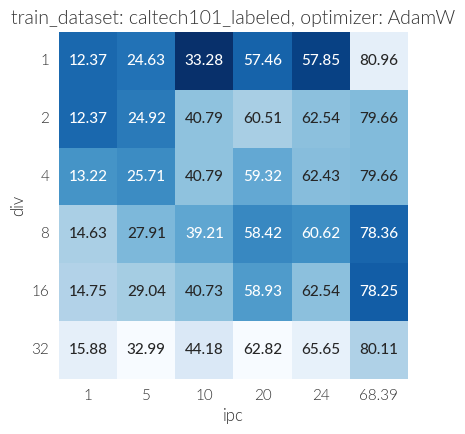

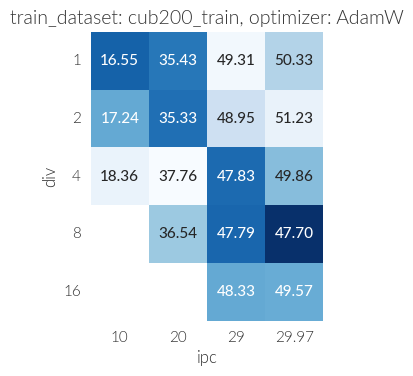

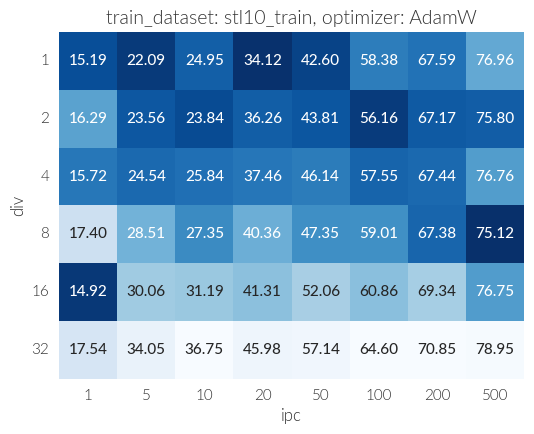

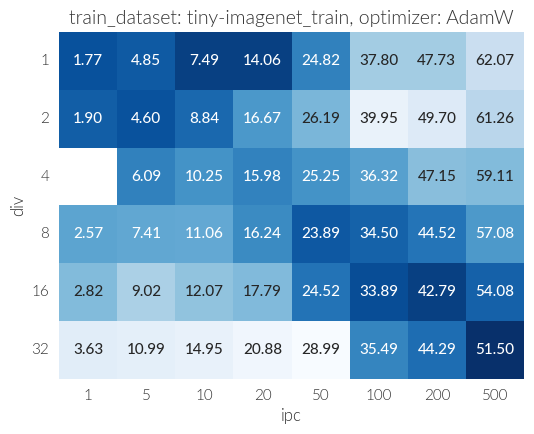

In [30]:
import matplotlib.ticker as ticker
import polars as pl

def format_axis_label(val: float | str) -> str:
    """整数以外の数値を小数点第2位に整形する。"""
    try:
        f_val = float(val)
        if f_val.is_integer():
            return str(int(f_val))
        return f"{f_val:.2f}"
    except (ValueError, TypeError):
        return str(val)

def format_pivot_columns(df: pl.DataFrame, group_cols: list | None = None) -> pl.DataFrame:
    """Pivotテーブルのカラム数値ソートとインデックスの整形を行う。"""
    new_columns = (
        pl.DataFrame({"cols": df.columns})
        .with_columns(pl.col("cols").cast(pl.Float32, strict=False).alias("numeric"))
        .sort("numeric", maintain_order=True)["cols"]
        .to_list()
    )
    df = df.select(new_columns)

    if group_cols:
        if len(group_cols) == 1:
            idx_alias = group_cols[0]
        else:
            idx_alias = f"({', '.join(group_cols)})"
            df = df.with_columns(
                (pl.lit("(") + pl.concat_str([pl.col(c).cast(pl.String) for c in group_cols], separator=", ") + pl.lit(")")).alias(idx_alias)
            )
        
        existing_cols = [c for c in group_cols if c in df.columns]
        if existing_cols:
            df = df.sort(existing_cols, descending=False).select(idx_alias, pl.col(new_columns).exclude(existing_cols))
            
    return df

plt.style.use(['./common.mplstyle'])
plt.rcParams['axes.titleweight'] = 300
plt.rcParams['axes.labelweight'] = 300

ext_columns = ext_columns if isinstance(ext_columns, list) else [ext_columns]
piv_values = piv_values if isinstance(piv_values, list) else [piv_values]
piv_on = piv_on if isinstance(piv_on, list) else [piv_on]

ext_l_df = df_e.select(ext_columns).unique().sort(ext_columns)

for i, ext_row_dict in enumerate(ext_l_df.iter_rows(named=True)):
    try:
        fig, ax = None, None
        for piv_value in piv_values:
            filter_condition = pl.all_horizontal([(pl.col(k) == v) for k, v in ext_row_dict.items()])
            df_ext = df_e.filter(filter_condition)
            
            target_on = piv_on[0]
            if len(piv_on) > 1:
                target_on = f"({', '.join(piv_on)})"
                df_ext = df_ext.with_columns(
                    (pl.lit("(") + pl.concat_str([pl.col(c).cast(pl.String) for c in piv_on], separator=", ") + pl.lit(")")).alias(target_on)
                )

            df_piv = df_ext.pivot(
                values=piv_value, index=piv_indices, on=target_on, sort_columns=True, aggregate_function=agg
            ).pipe(format_pivot_columns, group_cols=piv_indices)
            
            ax_x = df_piv.columns[1:]
            ax_y = df_piv[df_piv.columns[0]]
            data = df_piv.select(ax_x).to_numpy()
            
            title_parts = [f"{k}: {v}" for k, v in ext_row_dict.items()]
            title_str = ", ".join(title_parts)
            
            if np.issubdtype(data.dtype, np.number):
                annot = data.copy()

                if axis is not None:
                    if norm == "minmax":
                        min_vals = np.nanmin(data, axis=axis, keepdims=True)
                        max_vals = np.nanmax(data, axis=axis, keepdims=True)
                        data = (data - min_vals) / (max_vals - min_vals + 1e-8)
                
                    elif norm == "zscore":
                        mean_vals = np.nanmean(data, axis=axis, keepdims=True)
                        std_vals = np.nanstd(data, axis=axis, keepdims=True)
                        data = (data - mean_vals) / (std_vals + 1e-8)

                if piv_value[-4:] == "_acc":
                    annot *= 100
                
                fig, ax = plt.subplots(figsize=(len(ax_x)*square_size, len(ax_y)*square_size))

                hm_kwargs = {
                    "cmap": "Blues_r",
                    "cbar": False,
                    "fmt": ".2f",
                    "annot_kws": {"size": 11, "fontweight": 500}
                }

                ax = sns.heatmap(data, annot=annot, square=False, **hm_kwargs)
                
                ax.set_title(title_str, fontsize=14)
                ax.set_xlabel(target_on, fontsize=12)
                ax.set_ylabel(ax_y.name, fontsize=12, rotation=90)

                ax.set_xticklabels([format_axis_label(x) for x in ax_x], fontsize=11, rotation=0)
                ax.set_yticklabels([format_axis_label(y) for y in ax_y], fontsize=11, rotation=0)
                
                plt.show()
        
            else:
                plt.style.use(['./line.mplstyle'])
                df_step = df_ext.pivot(
                    values=x_col, index=piv_indices, on=target_on, sort_columns=True, aggregate_function=agg
                ).pipe(format_pivot_columns, group_cols=piv_indices)

                _ax_x = df_step.columns[1:]
                step_data = df_step.select(_ax_x).to_numpy()
                
                nrows, ncols = data.shape
                
                if fig is None:
                    fig, axes = plt.subplots(
                        nrows, ncols, 
                        figsize=(ncols * graph_size[0], nrows * graph_size[1]), 
                        sharex=False, sharey=False, squeeze=False
                    )
                
                fig.suptitle(title_str, fontsize=16)

                for i in range(nrows):
                    for j in range(ncols):
                        ax = axes[i, j]
                        
                        x_data = step_data[i, j]
                        y_data = data[i, j]
                        
                        if x_data is not None and y_data is not None:
                            filtered_points = [(x, y) for x, y in zip(x_data, y_data) if y is not None and not np.isnan(y)]
                            if len(filtered_points) > 1:
                                sorted_points = sorted(filtered_points, key=lambda point: point[0])
                                x_plot, y_plot = zip(*sorted_points)
                                ax.plot(x_plot, y_plot, label=piv_value)

                        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format_axis_label(x)))
                        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: format_axis_label(y)))

                        ax.tick_params(axis='both', which='major') 
                        legend = ax.legend()
                        
                        if ylim:
                            ax.set_ylim([0, 1.005])
            
                for i, row_label in enumerate(ax_y):
                    axes[i, 0].set_ylabel(row_label, rotation=0, ha='right', va='center', fontsize=10)

                for j, col_label in enumerate(ax_x):
                    axes[-1, j].set_xlabel(col_label, fontsize=10)
                    
                fig.supxlabel(target_on, fontsize=12)
                fig.supylabel(ax_y.name, fontsize=12)
                
                plt.tight_layout(rect=[0.02, 0.02, 1, 0.98])
    except ValueError as e:
        print(f"Skipping combination {ext_row_dict} due to error: {e}")

plt.show()